<a href="https://colab.research.google.com/github/MohamedMostafaSal/UnstructuredProjects/blob/main/CVBasics/Torch_Finetuning_For_Dummies_Defect_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

  https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


In [ ]:
!gdown --id 1rYI9ARFM1e55gxJEllb_avR_N9IKJsuM
!unzip -qq "/content/casting_data.zip" -d "/content/casting_data/"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rYI9ARFM1e55gxJEllb_avR_N9IKJsuM
To: /content/casting_data.zip
100% 73.0M/73.0M [00:00<00:00, 370MB/s]
replace /content/casting_data/casting_data/casting_data/test/def_front/cast_def_0_1059.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.0+cu113
Torchvision Version:  0.13.0+cu113


In [ ]:
#[resnet, alexnet, vgg, squeezenet, densenet, inception]

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/content/casting_data/casting_data/casting_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
#Data Loader 
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(root="/content/casting_data/casting_data/casting_data/train")
test_dataset = datasets.ImageFolder(root="/content/casting_data/casting_data/casting_data/test")

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
 )

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
 )

In [ ]:
len(train_dataloader)

830

In [ ]:
len(test_dataloader)

90

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

# Centre crop is a mistake for this dataset
#Add normalisation to your images (Get them from the imageNet documentation when needed)

data_transforms = {
    'train': transforms.Compose([
#        transforms.RandomResizedCrop(input_size),
        transforms.Resize(input_size),
#        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
#        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2815 Acc: 0.8726
test Loss: 0.0988 Acc: 0.9706

Epoch 1/14
----------
train Loss: 0.1376 Acc: 0.9496
test Loss: 0.0715 Acc: 0.9874

Epoch 2/14
----------
train Loss: 0.1060 Acc: 0.9613
test Loss: 0.0550 Acc: 0.9860

Epoch 3/14
----------
train Loss: 0.0946 Acc: 0.9649
test Loss: 0.0950 Acc: 0.9650

Epoch 4/14
----------
train Loss: 0.0880 Acc: 0.9665
test Loss: 0.0449 Acc: 0.9874

Epoch 5/14
----------
train Loss: 0.0865 Acc: 0.9679
test Loss: 0.0486 Acc: 0.9846

Epoch 6/14
----------
train Loss: 0.0723 Acc: 0.9750
test Loss: 0.0525 Acc: 0.9804

Epoch 7/14
----------
train Loss: 0.0729 Acc: 0.9717
test Loss: 0.0328 Acc: 0.9888

Epoch 8/14
----------
train Loss: 0.0707 Acc: 0.9742
test Loss: 0.0345 Acc: 0.9874

Epoch 9/14
----------
train Loss: 0.0675 Acc: 0.9748
test Loss: 0.0527 Acc: 0.9818

Epoch 10/14
----------
train Loss: 0.0667 Acc: 0.9765
test Loss: 0.0304 Acc: 0.9930

Epoch 11/14
----------
train Loss: 0.0677 Acc: 0.9763
test Loss: 0.0799 Acc: 0.9664

Epoch 12/14


Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if

train Loss: 0.6741 Acc: 0.5703
test Loss: 0.6500 Acc: 0.6336

Epoch 1/14
----------
train Loss: 0.6795 Acc: 0.5720
test Loss: 0.6582 Acc: 0.6336

Epoch 2/14
----------
train Loss: 0.6388 Acc: 0.5830
test Loss: 0.6596 Acc: 0.6336

Epoch 3/14
----------
train Loss: 0.6536 Acc: 0.6175
test Loss: 0.4176 Acc: 0.8615

Epoch 4/14
----------
train Loss: 0.5529 Acc: 0.6958
test Loss: 0.4009 Acc: 0.8266

Epoch 5/14
----------
train Loss: 0.4677 Acc: 0.7826
test Loss: 0.3995 Acc: 0.7664

Epoch 6/14
----------
train Loss: 0.4323 Acc: 0.8022
test Loss: 0.3121 Acc: 0.8755

Epoch 7/14
----------
train Loss: 0.4185 Acc: 0.8079
test Loss: 0.2739 Acc: 0.8979

Epoch 8/14
----------
train Loss: 0.2335 Acc: 0.9062
test Loss: 0.3476 Acc: 0.8196

Epoch 9/14
----------
train Loss: 0.1509 Acc: 0.9457
test Loss: 0.0863 Acc: 0.9748

Epoch 10/14
----------
train Loss: 0.0903 Acc: 0.9727
test Loss: 0.0571 Acc: 0.9846

Epoch 11/14
----------
train Loss: 0.0713 Acc: 0.9762
test Loss: 0.0827 Acc: 0.9692

Epoch 12/14


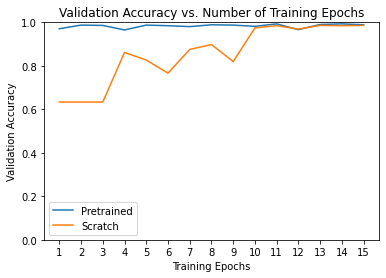

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()